In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numpy.random as nprd
import numpy.linalg as npla
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import bootstrap_plot
import statsmodels.api as sm
from feature_selection import FeatureSelection as fs

## Get rid of useless data and change string into computable datatype

In [3]:
data = pd.read_csv("companies_years_2009_2020_p4_v1_total.csv")
data_new = data.drop(columns = ['exchange', 'href', 'company_address', 'phone', 'company_name','Unnamed: 0', 'ticker'])
tag = data_new.columns
data_new['date_of_priced'] = pd.to_datetime(data_new['date_of_priced'])
change_tag = ['dollar_value_of_shares','shares_offered', 'shares_outstanding','1','2','3','4','5']
for idx in change_tag:
    data_new.update(data_new[idx].str.replace(r'\$', ''))
    data_new.update(data_new[idx].str.replace(r'\,', '').astype(float))
data_new[['shares_offered','dollar_value_of_shares','shares_outstanding']] = data_new[['shares_offered','dollar_value_of_shares','shares_outstanding']].astype(float)

## Replace all 0 in week 1,2,3,4,5 with null

In [4]:
data_new[['1','2','3','4','5']] = data_new[['1','2','3','4','5']].replace(0 ,np.nan)
data_new['date_of_priced'] = pd.to_datetime(data_new['date_of_priced'])
data_new.isnull().sum()

share_price                0
shares_offered             0
dollar_value_of_shares     0
date_of_priced             0
employees                  0
shares_outstanding         0
stock_valuation            0
sicdescription             0
ebit                       0
grossprofit                0
netincome                  0
totalrevenue               0
costofrevenue              0
totalassets                0
revenue_growth             0
1                         44
2                         44
3                         44
4                         44
5                         44
dtype: int64

## Delete all null data

In [17]:
data_nonzero = data_new[~(data_new['1'].isnull()) ]
data_nonzero.to_csv("ClearedData_deleteNulls.csv",index = False)
data_nonzero

,share_price,shares_offered,dollar_value_of_shares,date_of_priced,employees,shares_outstanding,stock_valuation,sicdescription,ebit,grossprofit,netincome,totalrevenue,costofrevenue,totalassets,revenue_growth,1,2,3,4,5
0,10.5,13500000.0,1.417500e+08,2009-04-15,2971,53139723.0,5.579671e+08,Services-Educational Services,33420000.0,155468000.0,26431000.0,2.182900e+08,6.282200e+07,1.292460e+08,1.546874,11.10,12.05,12.010,11.65,11.00
1,6.0,1700000.0,1.020000e+07,2009-07-30,96,3951811.0,2.371087e+07,"Oil and Gas Field Services, Not Elsewhere Clas...",2436607.0,3789779.0,1691949.0,9.592261e+06,5.802482e+06,8.933083e+06,0.262541,27.85,29.75,32.350,37.05,45.70
2,17.0,5000000.0,8.500000e+07,2009-08-11,59,17091191.0,2.905502e+08,Pharmaceutical Preparations,7282221.0,32029488.0,4766249.0,3.507516e+07,3.045672e+06,3.111919e+07,0.249846,16.83,17.00,17.045,17.01,16.80
3,10.0,30000000.0,3.000000e+08,2009-09-25,21700,156092873.0,1.560929e+09,Services-Hospitals,196408000.0,361521000.0,22441000.0,2.153362e+09,1.791841e+09,2.562425e+09,0.081186,10.09,10.45,10.090,10.07,10.00
4,14.0,5700000.0,7.980000e+07,2009-10-02,553,21493655.0,3.009112e+08,Arrangement of Transportation of Freight and C...,4945195.0,43090276.0,2875556.0,2.028076e+08,1.597174e+08,4.590902e+07,1.124508,14.06,14.00,14.000,13.51,12.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,10.5,58750000.0,6.168750e+08,2020-11-19,3355,58750000.0,6.168750e+08,"Perfumes, Cosmetics and Other Toilet Preparations",20638000.0,276736000.0,10055000.0,4.351560e+08,1.584200e+08,2.886020e+08,3.702610,18.40,20.03,18.240,17.15,16.86
446,27.0,60000000.0,1.620000e+09,2020-11-20,390,88965664.0,2.402073e+09,Pharmaceutical Preparations,23988000.0,76291000.0,-4470000.0,1.431400e+08,6.684900e+07,5.777960e+08,0.155912,29.85,29.00,26.290,26.96,29.16
447,23.0,46600000.0,1.071800e+09,2020-11-20,2900,277431755.0,6.380930e+09,Services-Miscellaneous Health and Allied Servi...,183597000.0,395431000.0,-20850000.0,7.783270e+08,3.828960e+08,2.580674e+09,0.043125,25.10,27.95,27.000,26.76,27.97
448,10.0,2400000.0,2.400000e+07,2020-11-24,14,7577677.0,7.577677e+07,Ship And Boat Building And Repairing,333700.0,1285364.0,233066.0,2.869377e+06,1.584013e+06,1.914562e+06,1.256569,14.44,14.21,14.120,13.15,12.79


In [34]:
data_cal = data_nonzero.drop(columns = ['date_of_priced', 'sicdescription'])
target = data_nonzero[['1','2','3','4','5']]
tag = ['1','2','3','4','5']

print("Features selected by forward selection for week 1:", fs.forward_selection(data_cal.drop(columns = tag), target['1'], 0.05))
print("Features selected by forward selection for week 2:", fs.forward_selection(data_cal.drop(columns = tag[1:]), target['2'], 0.05))
print("Features selected by forward selection for week 3:", fs.forward_selection(data_cal.drop(columns = tag[2:]), target['3'], 0.05))
print("Features selected by forward selection for week 4:", fs.forward_selection(data_cal.drop(columns = tag[3:]), target['4'], 0.05))
print("Features selected by forward selection for week 5:", fs.forward_selection(data_cal.drop(columns = tag[4:]), target['5'], 0.05))
print("\n")
print("Features selected by forward selection for week 1:", fs.forward_selection(data_cal.drop(columns = tag), target['1'], 0.05))
print("Features selected by forward selection for week 2:", fs.forward_selection(data_cal.drop(columns = tag), target['2'], 0.05))
print("Features selected by forward selection for week 3:", fs.forward_selection(data_cal.drop(columns = tag), target['3'], 0.05))
print("Features selected by forward selection for week 4:", fs.forward_selection(data_cal.drop(columns = tag), target['4'], 0.05))
print("Features selected by forward selection for week 5:", fs.forward_selection(data_cal.drop(columns = tag), target['5'], 0.05))
print("\n")
print("Features selected by backward elimination for week 1:", fs.backward_elimination(data_cal.drop(columns = tag), target['1'], 0.05)[0])
print("Features selected by backward elimination for week 2:", fs.backward_elimination(data_cal.drop(columns = tag[1:]), target['2'], 0.05)[0])
print("Features selected by backward elimination for week 3:", fs.backward_elimination(data_cal.drop(columns = tag[2:]), target['3'], 0.05)[0])
print("Features selected by backward elimination for week 4:", fs.backward_elimination(data_cal.drop(columns = tag[3:]), target['4'], 0.05)[0])
print("Features selected by backward elimination for week 5:", fs.backward_elimination(data_cal.drop(columns = tag[4:]), target['5'], 0.05)[0])
print("\n")
print("Features selected by backward elimination for week 1:", fs.backward_elimination(data_cal.drop(columns = tag), target['1'], 0.05)[0])
print("Features selected by backward elimination for week 2:", fs.backward_elimination(data_cal.drop(columns = tag), target['2'], 0.05)[0])
print("Features selected by backward elimination for week 3:", fs.backward_elimination(data_cal.drop(columns = tag), target['3'], 0.05)[0])
print("Features selected by backward elimination for week 4:", fs.backward_elimination(data_cal.drop(columns = tag), target['4'], 0.05)[0])
print("Features selected by backward elimination for week 5:", fs.backward_elimination(data_cal.drop(columns = tag), target['5'], 0.05)[0])


Features selected by forward selection for week 1: ['share_price']
Features selected by forward selection for week 2: ['1']
Features selected by forward selection for week 3: ['2', '1', 'share_price', 'dollar_value_of_shares']
Features selected by forward selection for week 4: ['1', '3', '2']
Features selected by forward selection for week 5: ['1', '4', '2', '3']


Features selected by forward selection for week 1: ['share_price']
Features selected by forward selection for week 2: []
Features selected by forward selection for week 3: ['share_price']
Features selected by forward selection for week 4: ['share_price']
Features selected by forward selection for week 5: ['share_price']


Features selected by backward elimination for week 1: ['share_price']
Features selected by backward elimination for week 2: ['1' 'netincome' 'dollar_value_of_shares' 'shares_outstanding'
 'shares_offered' 'share_price' 'totalassets' 'costofrevenue'
 'stock_valuation' 'employees' 'totalrevenue' 'ebit']
Featu

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     2.870
Date:                Thu, 08 Apr 2021   Prob (F-statistic):           0.000567
Time:                        20:05:23   Log-Likelihood:                -1348.5
No. Observations:                 406   AIC:                             2725.
Df Residuals:                     392   BIC:                             2781.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1

Text(0, 0.5, '(day5 - share_price)/share_price')

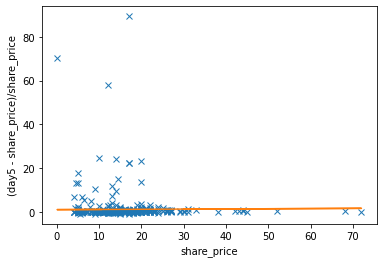

In [33]:
X = data_cal.drop(columns = ['1','2','3','4','5'])
X = sm.add_constant(X)
y = (data_cal['5'] - data_cal['share_price'])/ data_cal['share_price']
model = sm.OLS(y,X)
result = model.fit();
print(result.summary())
plt.plot(data_cal['share_price'],y,'x', label = 'data' )
a = result.params['share_price']
b = result.params['const']
plt.plot(data_cal['share_price'], data_cal['share_price'] * a + b, label = 'prox' )
plt.xlabel("share_price")
plt.ylabel("(day5 - share_price)/share_price")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                    0.3125
Date:                Thu, 08 Apr 2021   Prob (F-statistic):              0.990
Time:                        20:00:50   Log-Likelihood:                -2419.4
No. Observations:                 406   AIC:                             4867.
Df Residuals:                     392   BIC:                             4923.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     13

Text(0, 0.5, 'day5 - share_price')

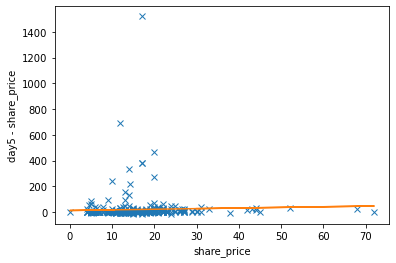

In [30]:
X = data_cal.drop(columns = ['1','2','3','4','5'])
X = sm.add_constant(X)
y = (data_cal['5'] - data_cal['share_price'])
model = sm.OLS(y,X)
result = model.fit();
print(result.summary())
plt.plot(data_cal['share_price'],y,'x', label = 'data' )
a = result.params['share_price']
b = result.params['const']
plt.plot(data_cal['share_price'], data_cal['share_price'] * a + b, label = 'prox' )
plt.xlabel("share_price")
plt.ylabel("day5 - share_price")